In this notebook I use the external plots function inside the class for actually plotting the SFR gradients for each subsample (low, medium, and high) and then define a new method for making the combined plots

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import math
import ast
import csv
import time
import astropy
from astropy import io
from astropy.io import fits, ascii
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.modeling.models import Gaussian2D
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxesSubplot
from astropy.table import QTable, Table, Column
from PIL import Image
from astropy import units as u
from astropy.cosmology import WMAP5, WMAP7
from astropy.coordinates import Distance

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib as mpl
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import os

import scipy.ndimage
import scipy.stats as sci
import matplotlib.gridspec as gridspec
import numpy.ma as ma
import re

import marvin
from marvin.tools import Maps
import marvin.utils.plot.map as mapplot
from marvin.tools import Cube
from marvin.tools.vacs import VACs
from marvin.utils.general import get_drpall_table

import warnings
warnings.filterwarnings("ignore")

/packages/python3.7.7/lib/python3.7/site-packages/sdss_marvin-2.7.1-py3.7.egg/marvin/core/exceptions.py:51: UserWarning: cannot initiate Sentry error reporting: [Errno 6] No such device or address.
  UserWarning)
[INFO]: No release version set. Setting default to DR17
[WARNING]: path /homes/emartignon/sas/mangawork/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /homes/emartignon/sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)


In [2]:
os.makedirs('Plots/WholeSampleData', exist_ok=True) # creating directories for plots made with an entire sample to be saved to
os.makedirs('Plots/Subsamples', exist_ok=True) # creating directory for all plots of any subsamples to be saved to

# Plotting SFR gradients for the whole sample

### Opening FITS file as an astropy table

In [3]:
hdul_final = fits.open('whole_sample_binned_pergalaxy.fits') #opening fits file I created in different notebook to
                                                                #save my mean SFR gradient calculations to
gals_data=Table(hdul_final[1].data) #turning the fits file data into an astropy table
gals_data #outputting the table to see what the data looks like

PlateIFU,MaNGA ID,SFR (binned avg) [10],Radii (binned avg) [10],Distance (cm),Redshift,Log(M),eta_k
str11,str9,float64,float64,float64,float64,float64,float64
11866-12705,1-1009,-0.3518002068298216 .. nan,0.0 .. 2.25,8.948313480907228e+26,0.064824656,11.1784377138807,-0.613014
12071-9102,1-106670,-2.6102945628750205 .. nan,0.0 .. 2.25,2.0409471842239263e+26,0.015345705,9.33868433186837,-0.5142199
12510-3701,1-10760,-0.8430842514723946 .. -2.877056111308325,0.0 .. 2.25,9.962635414950376e+26,0.07180949,11.1694237494867,-0.0188906
11866-3701,1-1081,-1.7119458180593696 .. -2.818402378388864,0.0 .. 2.25,6.329403775426763e+26,0.046475276,10.4494924512784,-0.2605647
8084-12703,1-109378,-2.0106366999681438 .. nan,0.0 .. 2.25,5.297099074811307e+26,0.0391104,11.0350643813109,0.1205672
12512-9101,1-113,nan .. nan,0.0 .. 2.25,9.349413576183783e+26,0.06759457,11.0757306019457,-0.1899883
11836-12705,1-1151,-2.538573440663775 .. nan,0.0 .. 2.25,6.072262541469535e+26,0.04464796,10.2619454420827,-0.0062719
8144-12703,1-120935,nan .. nan,0.0 .. 2.25,5.269008683356961e+26,0.0389089,11.1753081605569,0.6137283
8144-9101,1-120941,-3.1828926316877824 .. nan,0.0 .. 2.25,2.1004271357355855e+26,0.0157875,10.1487252992221,0.2145598


In [4]:
'''Defining function that retrieves binned SFR, radius, environment, and redshift data from the astropy table of data
and converts them all to numpy arrays or lists of numpy arrays for plotting'''

def extract(data): # function takes astropy table form of data as argument
    Env_list = np.array(data['eta_k']) # extracting 'eta_k' column from data and converting to numpy array
    Z_list = np.array(data['Redshift']) # extracting 'Redshift' column from data and converting to numpy array
    M_list = np.array(data['Log(M)']) # extracting 'Log(M)' column from data and converting to numpy array

    Sfr_list_initial = data['SFR (binned avg)'].tolist() # creating list of SFR binned avg values for each galaxy, each of which is stored in its own list

    # converting list of SFR lists to list of SFR numpy arrays
    Sfr_list = [] # creating empty list to put SFR numpy arrays in
    for i in range(0, len(Sfr_list_initial)):
        gal = np.array(Sfr_list_initial[i]) # converting each SFR binned avg list to numpy array
        Sfr_list.append(gal) # appending numpy array to Sfr_list

    R_list_initial = data['Radii (binned avg)'] # creating list of radius binned avg values for each galaxy, each of which is stored in its own list

    # converting list of radius values lists to list of radius values numpy arrays
    R_list = [] # creating empty list to put SFR numpy arrays in
    for i in range(0, len(R_list_initial)):
        rad = np.array(R_list_initial[i]) # converting each radius binned avg list to numpy array
        R_list.append(rad) # appending numpy array to R_list
        
    return Sfr_list, R_list, Env_list, Z_list, M_list # returning lists of SFR, radius, environment, redshift, and mass values



In [5]:
SFR_list, r_list, env_list, z_list, logM_list = extract(gals_data) #calling the extract function to extract SFR, radius, environment, redshift, and mass values from the gals_data astropy table

### Plotting using the FITS data

In [20]:
'''Defining function that concatenates the SFR and radius binned data for a given sample and plots them; and
also plots the binned average of the whole sample. For the savefig argument, give it a string that you want
to be the title of the png file for that plot, if you want it saved'''

def plots(SFRs, radii, grouping='', subsample='', plot_title=None, dots=False, line_style=None, savefig=None, showfig=True, histogram=False): # Function to plot SFR gradient data

    R = np.concatenate(radii, axis=0) # Concatenating radii arrays
    SFR = np.concatenate(SFRs, axis=0) # Concatenating SFR arrays
    valid_indices = ~np.isnan(SFR) # Finding valid indices where SFR is not NaN
    R, SFR = R[valid_indices], SFR[valid_indices] # Filtering out NaN values

    # Computing the mean of the sample for each radial bin
    SFRs_mean, radii_mean, binnumber = sci.binned_statistic(R, SFR, bins=10, range=[0,2.5]) # Finding average SFR as a function of radius across the whole sample
    SFRs_std, radii_std, binnumber = sci.binned_statistic(R, SFR, bins=10, range=[0,2.5], statistic='std') # Finding standard deviation of SFR as a function of radius across the whole sample
    avcount, radii_mean, binnumber = sci.binned_statistic(R, SFR, bins=10, range=[0,2.5], statistic='count') # Returning sample size in each bin
    avcount = np.array(avcount)
    
    # Calculating standard error of the mean
    SEM = SFRs_std / np.sqrt(avcount)
    
       # Defining colors and titles based on grouping
    color_map = {
        '': ('orange', 'dodgerblue', 'SFR Gradient Binned Average Across All Environments'),
        'Low': ('lightskyblue', 'mediumblue', 'SFR Gradient Binned Average for Galaxies in Low'),
        'Medium': ('thistle', 'mediumvioletred', 'SFR Gradient Binned Average for Galaxies in Medium'),
        'High': ('gold', 'darkorange', 'SFR Gradient Binned Average for Galaxies in High')
    }
    
    # Getting the colors and plot title based on the grouping, defaulting to ('gray', 'black', 'SFR Gradient')
    Color1, Color2, plot_title = color_map.get(grouping, ('gray', 'black', 'SFR Gradient'))

    # If grouping is specified, customize the plot title accordingly
    if grouping:
        plot_title = f"Mean SFR Gradient for Galaxies in {grouping} {subsample}"
    else:
        # Otherwise, set a default plot title for the whole sample
        plot_title = "Mean SFR Gradient for Whole Sample"


    # Plotting
    plt.figure(figsize=(8, 6)) # Setting figure size
    plt.title(plot_title) # Setting the plot title
    if dots:
        plt.scatter(R, SFR, color=Color1, s=20, alpha=0.5)  # Plotting the binned avg SFR values as a function of radius for each galaxy
    if line_style is None:
        line_style = '-'  # Default to solid line if no linestyle specified
    plt.plot(radii_mean[:-1], SFRs_mean, color=Color2, linewidth=2, linestyle=line_style, label=grouping) # Plotting mean SFR gradient
    plt.fill_between(radii_mean[:-1], SFRs_mean - (SEM), SFRs_mean + (SEM), color=Color2, alpha=0.3) # Plotting standard error of the mean
    plt.xlabel(r'$ R/R_{eff}$') # Setting x-axis label
    plt.ylabel('log(SFR)') # Setting y-axis label
    
    # Save figure if requested
    if savefig:
        first_word = subsample.split()[0] if subsample else None
        sampleavgsfr_name = f'Plots/Subsamples/{grouping}{first_word}{savefig}.png' if grouping and subsample else f'Plots/WholeSampleData/{savefig}.png' # Naming the file to save
        plt.savefig(sampleavgsfr_name, bbox_inches='tight') # Saving the figure
    
    # Show or close the figure based on `showfig`
    if showfig:
        plt.show()  # This actually displays the figure on screen
    else:
        plt.close()  # Close the figure to free up memory if not showing it
    
    # Creating a histogram of the counts (number of galaxies) per bin if requested
    if histogram:
        plt.figure(figsize=(8, 6)) # Setting figure size for the histogram
        plt.bar(radii_mean[:-1], avcount, width=np.diff(radii_mean)[0], color=Color2, alpha=0.7, edgecolor='black') # Plotting histogram
        plt.xlabel(r'$ R/R_{eff}$') # Setting x-axis label
        plt.ylabel('Counts') # Setting y-axis label
        plt.title(f'Histogram of Counts per Bin for {grouping} {subsample}' if grouping else 'Histogram of Counts per Bin for Whole Sample') # Setting title for histogram

        # Increase the number of ticks on the y-axis
        plt.yticks(np.arange(0, max(avcount)+1, step=max(avcount)/5))
        plt.show() # Showing the histogram
        
    return SFR, R, SFRs_mean, radii_mean, SEM # Returning SFR, radii, mean SFR, mean radii, and SEM


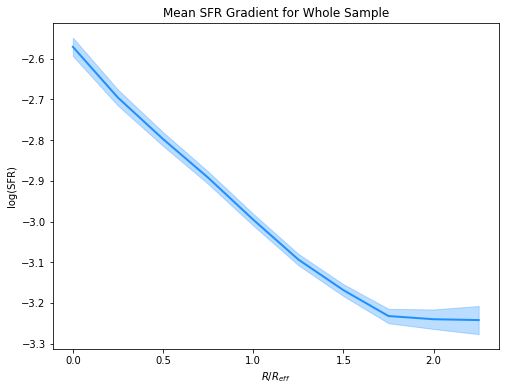

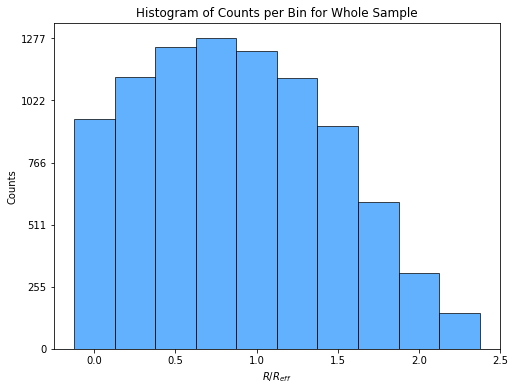

In [22]:
# Calling the plots function to generate a plot for the whole sample SFR data

SFR_wholesample, r_wholesample, SFR_wholesample_mean, r_wholesample_mean, SEM_wholesample = plots(SFR_list, r_list,
            '', '', dots=False, line_style=None, savefig='meanSFRgrad', showfig=True, histogram=True) 

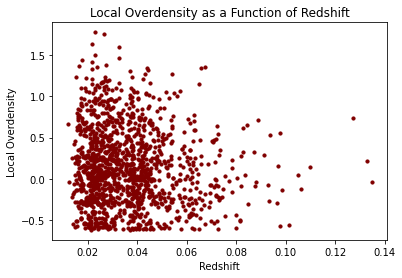

In [8]:
'''Plotting environment vs redshift for the entire sample to see distribution and use for
determining density groupings'''

plt.scatter(z_list, env_list, s=10, color='maroon') # Scatter plot of environmental density against redshift
plt.title('Local Overdensity as a Function of Redshift') # Setting the title of the plot
plt.xlabel('Redshift') # Setting the label for the x-axis
plt.ylabel('Local Overdensity') # Setting the label for the y-axis
env_redshift_name = 'Plots/WholeSampleData/env_redshift_scatter.png' # Defining the filename to save the plot
plt.savefig(env_redshift_name, bbox_inches='tight') # Saving the plot as an image file
plt.show() # Displaying the plot

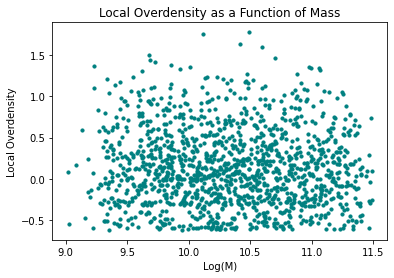

In [9]:
'''Plotting environment vs mass for the entire sample to see distribution and use for
determining density groupings'''

plt.scatter(logM_list, env_list, s=10, color='teal') # Scatter plot of environmental density against mass
plt.title('Local Overdensity as a Function of Mass') # Setting the title of the plot
plt.xlabel(r'Log(M)') # Setting the label for the x-axis
plt.ylabel('Local Overdensity') # Setting the label for the y-axis
env_redshift_name = 'Plots/WholeSampleData/env_mass_scatter.png' # Defining the filename to save the plot
plt.savefig(env_redshift_name, bbox_inches='tight') # Saving the plot as an image file
plt.show() # Displaying the plot


# Plotting SFR gradients for subsamples of galaxies in low, medium, and high density environments; and then low, medium, and high-mass galaxies

## Defining a class for dividing up the data and creating plots of different subsamples

In [16]:
class SFRGradientAnalysis:
    def __init__(self, data, attribute, min_threshold, max_threshold):
        # Initializing class attributes
        self.data = data
        self.attribute = attribute
        self.min_threshold = min_threshold
        self.max_threshold = max_threshold
        self.grouped_data = {
            'Low': None,
            'Medium': None,
            'High': None
        }
        self.extracted_data = {
            'Low': None,
            'Medium': None,
            'High': None
        }
    
    ''' 
    Defining method that separates given data into groups based on attribute, creating one dictionary with 3 keys
    '''
    def separate_by_threshold(self):
        # Separating data into groups based on specified attribute thresholds
        self.grouped_data['Low'] = self.data[self.data[self.attribute] <= self.min_threshold]
        self.grouped_data['Medium'] = self.data[(self.data[self.attribute] > self.min_threshold) & (self.data[self.attribute] <= self.max_threshold)]
        self.grouped_data['High'] = self.data[self.data[self.attribute] > self.max_threshold]

        
    ''' 
    Defining method that extracts and returns SFR, radii, environment, redshift, and mass data for the specified group,
    creating one dictionary with 3 keys
    '''
    def extract_data(self):
        for group in self.grouped_data.keys():
            if self.grouped_data[group] is not None:
                data_subset = self.grouped_data[group]
                SFR, r, env, z, logM = extract(data_subset) # Using the previously defined 'extract' function external to the class
                # populating dictionary of extracted data
                self.extracted_data[group] = {
                    'SFR': SFR,
                    'r': r,
                    'env': env,
                    'z': z,
                    'logM': logM
                }
            else:
                raise ValueError(f"The specified group '{group}' does not exist or has not been populated.")
        return self.extracted_data
          
    
    ''' 
    Defining method for plotting gradients by group/subsample, using the external plots() function
    '''
    def plot_sfr_gradient_by_group(self, subsample=None, plot_title=None, dots=False, line_style=None, savefig=None, showfig=True, histogram=False):
        # Extracting the relevant data for the specified group
        for group in self.extracted_data.keys():
            SFRs = self.extracted_data[group]['SFR'] # taking SFR out of dictionary to feed to plotting function
            radii = self.extracted_data[group]['r'] # taking r out of dictionary to feed to plotting function
            plots(SFRs, radii, grouping=group, subsample=subsample, dots=dots, line_style=line_style, savefig=savefig, showfig=showfig, histogram=histogram) # Calling the external 'plots' function with the extracted data
    
    
    ''' 
    Defining methods that prepares extracts info from dictionaries and prepares/pre-packages it for plotting
    '''
    def preparing_plots(self, group):
        
        SFRs = self.extracted_data[group]['SFR']
        radii = self.extracted_data[group]['r']
            
        R = np.concatenate(radii, axis=0) # Concatenating radii arrays
        SFR = np.concatenate(SFRs, axis=0) # Concatenating SFR arrays
        valid_indices = ~np.isnan(SFR) # Finding valid indices where SFR is not NaN
        R, SFR = R[valid_indices], SFR[valid_indices] # Filtering out NaN values

        # Computing the mean of the sample for each radial bin
        SFRs_mean, radii_mean, binnumber = sci.binned_statistic(R, SFR, bins=10, range=[0,2.5]) # Finding average SFR as a function of radius across the whole sample
        SFRs_std, radii_std, binnumber = sci.binned_statistic(R, SFR, bins=10, range=[0,2.5], statistic='std') # Finding standard deviation of SFR as a function of radius across the whole sample
        avcount, radii_mean, binnumber = sci.binned_statistic(R, SFR, bins=10, range=[0,2.5], statistic='count') # Returning sample size in each bin
        avcount = np.array(avcount)
    
        # Calculating standard error of the mean
        SEM = SFRs_std / np.sqrt(avcount)
        
        return R, SFR, SFRs_mean, radii_mean, SFRs_std, radii_std, avcount, SEM
    

    '''
    Defining method that plots the low, medium, and high groups / subsamples all on the same plot 
    '''
    def plot_sfr_gradient_combined(self, subsample=None, dots=False, line_style=None, savefig=None, showfig=True):
         # Defining colors based on grouping
        color_map = {
            '': ('orange', 'dodgerblue'),
            'Low': ('lightskyblue', 'mediumblue'),
            'Medium': ('thistle', 'mediumvioletred'),
            'High': ('gold', 'darkorange')
            }
        
        plt.figure(figsize=(8,6))
        for group in self.extracted_data.keys(): # looping through each of the keys in the dictionary, each of which has a subdictionary containing SFR, r, env, z, and logM for each galaxy in a group / subsample
            R, SFR, SFRs_mean, radii_mean, SFRs_std, radii_std, avcount, SEM = self.preparing_plots(group)
            if line_style is None:
                line_style = '-'  # Default to solid line if no linestyle specified
            Color1, Color2 = color_map.get(group, ('gray', 'black', 'SFR Gradient')) # extracting colors for plotting from colormap
            plt.plot(radii_mean[:-1], SFRs_mean, color=Color2, linewidth=2, linestyle=line_style, label=group) # Plotting mean SFR gradient
            plt.fill_between(radii_mean[:-1], SFRs_mean - (SEM), SFRs_mean + (SEM), color=Color2, alpha=0.3) # Plotting standard error of the mean
            plt.scatter(R, SFR, color=Color1, s=20, alpha=0.5) if dots else None # Plotting the binned avg SFR values as a function of radius for each galaxy
        plt.legend() # creating legend
        plt.xlabel(r'$ R/R_{eff}$') # Setting x-axis label
        plt.ylabel('log(SFR)') # Setting y-axis label
        plt.title(f'Mean SFR Gradient for Low, Medium, and High-{subsample} Galaxies') # Setting the plot title
        #Save figure if requested
        if savefig:
            attribute=subsample.split()[0] if subsample else None #extracting subsample type for file naming
            sampleavgsfr_name = f'Plots/Subsamples/combined{attribute}_{savefig}.png' # Naming the file to save
            plt.savefig(sampleavgsfr_name, bbox_inches='tight') # Saving the figure
        plt.show() if showfig else plt.close()



## Grouping sample into low, medium, and high density galaxies and plotting SFR gradient

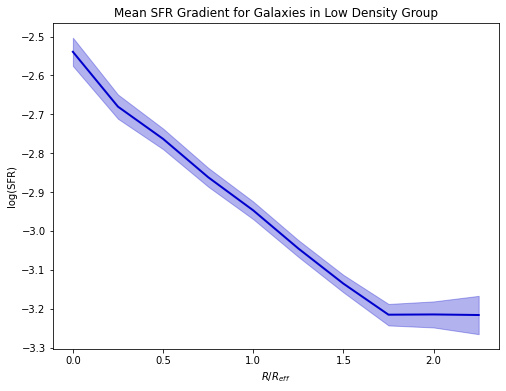

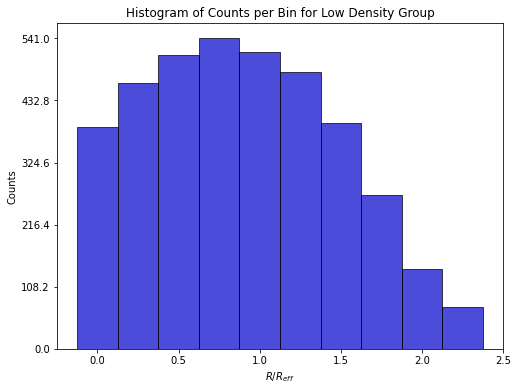

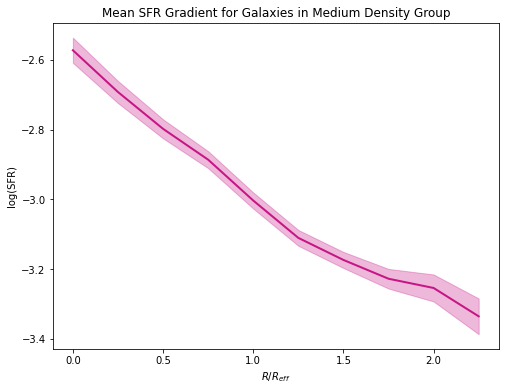

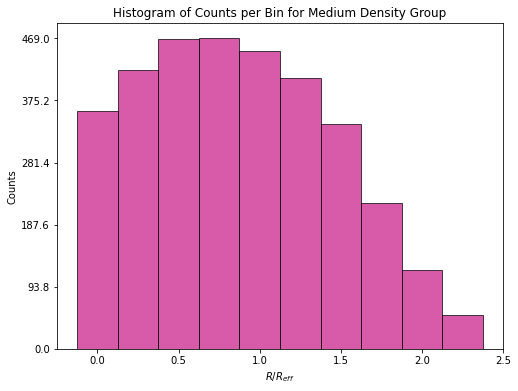

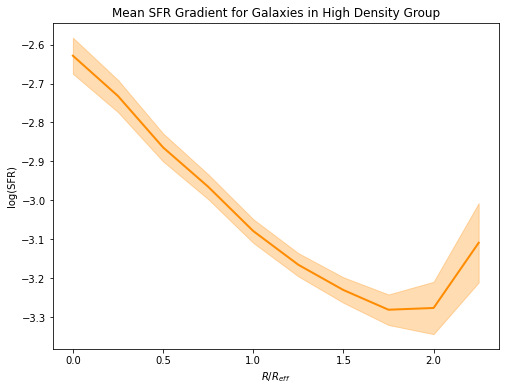

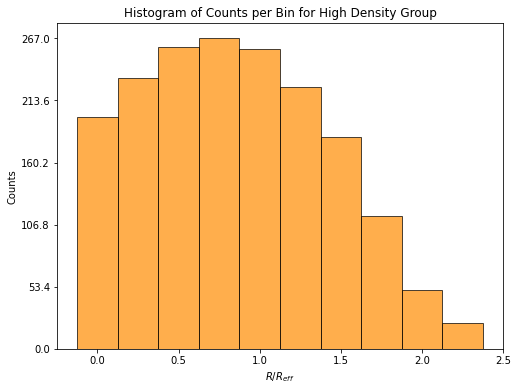

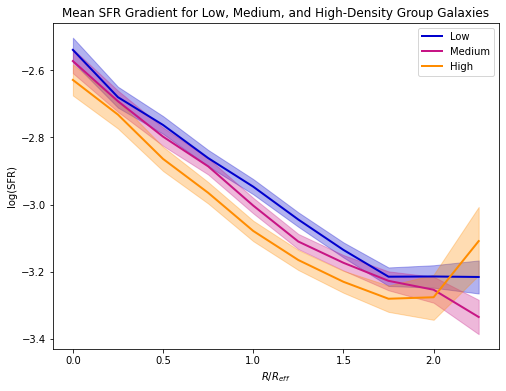

In [18]:
# Make new instance of SFRGradientAnalysis class (where we will evaluate density of galactic environments), and separate by threshold
density_sfr_analysis = SFRGradientAnalysis(gals_data, 'eta_k', 0, 0.5)
# Separate by threshold
density_sfr_analysis.separate_by_threshold()
# Extract data for each group
density_sfr_analysis.extract_data()

# Plotting SFR gradients for low, medium, and high density galaxies separately 
density_sfr_analysis.plot_sfr_gradient_by_group(subsample='Density Group', dots=False, line_style=None, savefig='meanSFRgrad', showfig=True, histogram=True)
    
# Plotting SFR gradients for low, medium, and high density galaxies together 
density_sfr_analysis.plot_sfr_gradient_combined(subsample='Density Group', dots=False, line_style=None, savefig='meanSFRgrad', showfig=True)


## Grouping sample into low, medium, and high mass galaxies and plotting SFR gradient

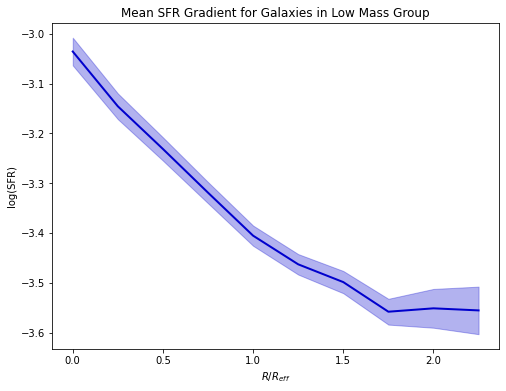

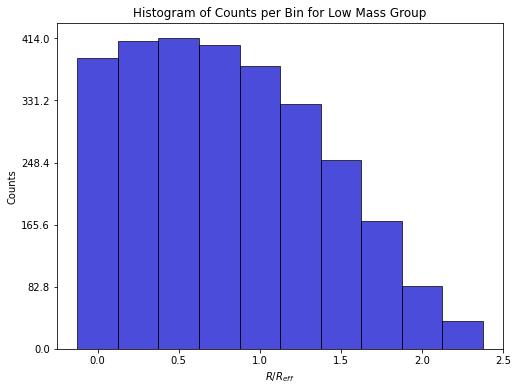

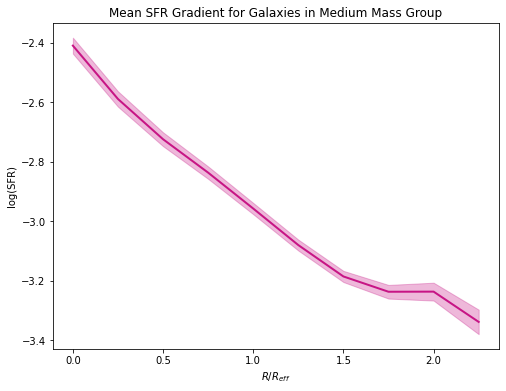

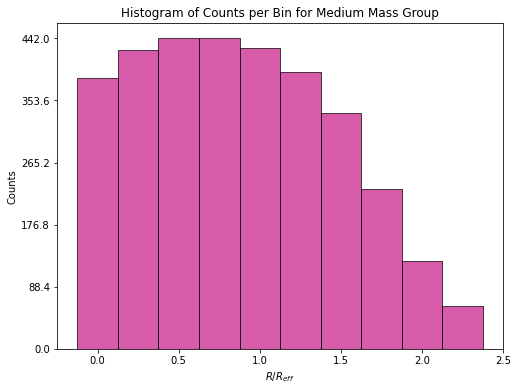

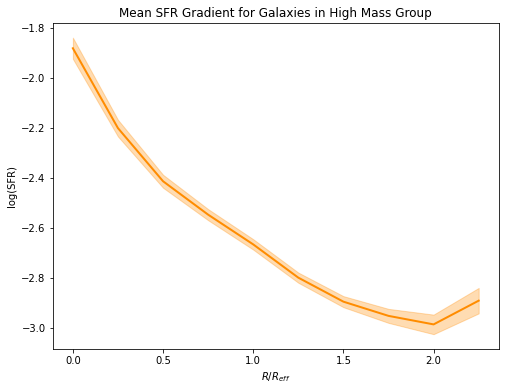

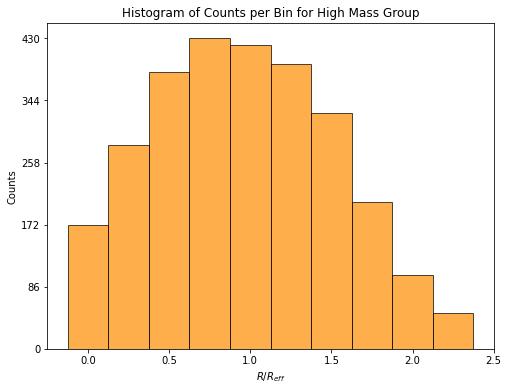

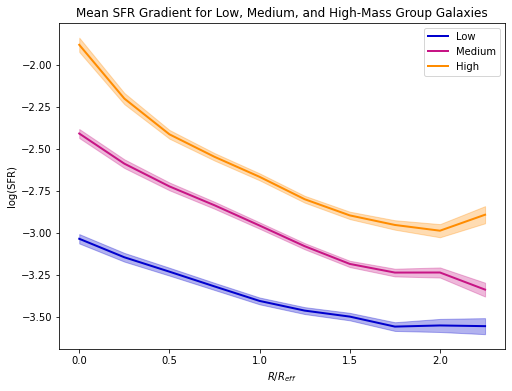

In [19]:
'''Separating data into low, medium, and high-mass subsamples and plotting'''

# Make new instance of SFRGradientAnalysis class (where we will evaluate density of galactic environments), and separate by threshold
mass_sfr_analysis = SFRGradientAnalysis(gals_data, 'Log(M)', 10, 10.6)
# Separate by threshold
mass_sfr_analysis.separate_by_threshold()
# Extract data for each group
mass_sfr_analysis.extract_data()

# Plotting SFR gradients for low, medium, and high mass galaxies separately 
mass_sfr_analysis.plot_sfr_gradient_by_group(subsample='Mass Group', dots=False, line_style=None, savefig='meanSFRgrad', showfig=True, histogram=True)

# Plotting SFR gradients for low, medium, and high mass galaxies together 
mass_sfr_analysis.plot_sfr_gradient_combined(subsample='Mass Group', dots=False, line_style=None, savefig='meanSFRgrad', showfig=True)
